<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/XRD_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install -q jarvis-tools spglib ase

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 30.7 MB/s eta 0:00:00


Ref: https://atomgpt.org/xrd

# Forward Problem

In [6]:
from jarvis.core.atoms import Atoms
#Silicon crystal structure example. These crystal-structure data are generally obtained from XRD-type experiments.
box = [[2.715, 2.715, 0], [0, 2.715, 2.715], [2.715, 0, 2.715]]
coords = [[0, 0, 0], [0.25, 0.25, 0.25]]
elements = ["Si", "Si"]
Si = Atoms(lattice_mat=box, coords=coords, elements=elements)
from ase.visualize import view
view(Si.make_supercell([2,2,2]).ase_converter(),viewer='x3d')

In [7]:
from ase.visualize import view
view(Si.get_conventional_atoms.make_supercell([2,2,2]).ase_converter(),viewer='x3d')

/usr/local/lib/python3.12/dist-packages/jarvis/analysis/structure/spacegroup.py:315: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  n = self._dataset["number"]


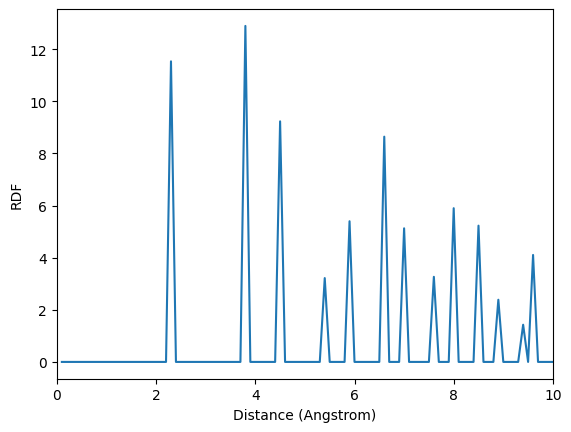

In [8]:
# RDF/PDF: Radial/Pair distribution function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
atoms=Si

dists=[]
for i in atoms.get_all_neighbors(r=10):
    for j in i:
      dists.append(j[2])
dists=np.array(dists)
hist, bins = np.histogram(dists, bins=np.arange(0.1, 10.2, 0.1))
number_density = atoms.num_atoms / atoms.volume
shell_vol = (
            4.0
            / 3.0
            * np.pi
            * (np.power(bins[1:], 3) - np.power(bins[:-1], 3))
        )

rdf = (
            hist / shell_vol / number_density / atoms.num_atoms
        )
plt.plot(bins[:-1], rdf)
plt.xlim([0,10])
plt.xlabel('Distance (Angstrom)')
plt.ylabel('RDF')
plt.show()

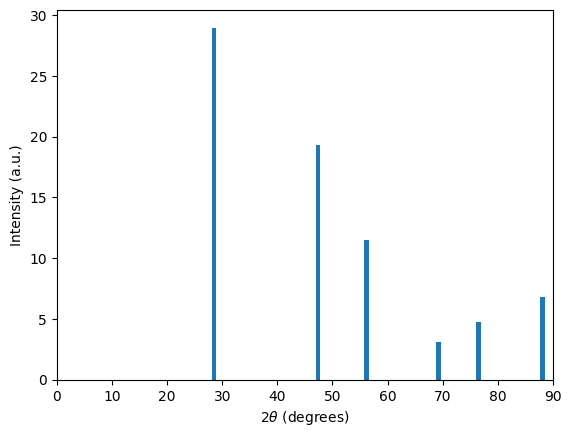

In [9]:
from jarvis.analysis.diffraction.xrd import XRD
theta,d_hkls,intens = XRD().simulate(atoms=Si)
import matplotlib.pyplot as plt

# Assuming `theta` and `intens` are defined lists or arrays of the same length.
plt.bar(theta, intens)
plt.xlim(0, 90)
plt.xlabel(r'2$\theta$ (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.show()


In [10]:
my_xrd_data="""elements HAS ALL Al
38.3301 28.0089
44.553 13.4885
64.8365 8.7086
77.8979 10.1859
82.0792 2.9489
98.6034 1.5015
111.4164 5.3945
115.9121 5.3881
136.4182 6.577
160.0414 17.798
"""


In [11]:
my_xrd_data = my_xrd_data.splitlines()
my_xrd_data

['elements HAS ALL Al',
 '38.3301 28.0089',
 '44.553 13.4885',
 '64.8365 8.7086',
 '77.8979 10.1859',
 '82.0792 2.9489',
 '98.6034 1.5015',
 '111.4164 5.3945',
 '115.9121 5.3881',
 '136.4182 6.577',
 '160.0414 17.798']

In [12]:
import numpy as np
elements = my_xrd_data[0].split('elements HAS ALL ')[1].split(',')
x=[]
y=[]
for i in my_xrd_data[1:]:
    tmp=i.split(' ')
    x.append(float(tmp[0]))
    y.append(float(tmp[1]))
x=np.array(x)
y=np.array(y)
y=y/np.max(y)

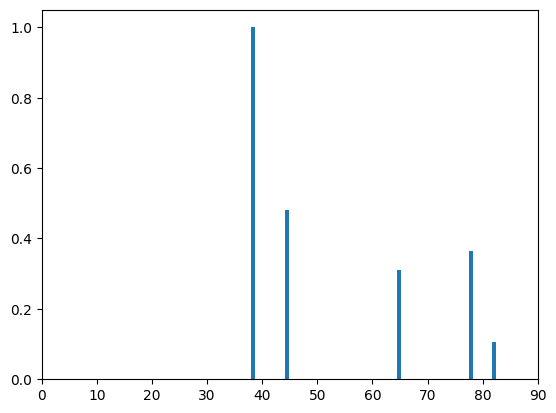

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.bar(x,y)
plt.xlim([0,90])
plt.show()

In [14]:
from jarvis.core.utils import baseline_als,recast_array
import numpy as np
# background = baseline_als(y, 10000, 0.001)
background = baseline_als(y, 10000, 0.000001)
y_corrected = np.array(y - background)
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.bar(x,y_corrected)
# plt.xlim([0,90])
# plt.show()

/usr/local/lib/python3.12/dist-packages/jarvis/core/utils.py:363: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  z = spsolve(Z, w * y)


In [15]:
x_range=[0,90]
intvl=0.1
y_corrected=y_corrected/np.max(y_corrected)

x, y_corrected = recast_array(
    x_original=x,
    y_original=y_corrected,
    x_new=np.arange(x_range[0], x_range[1], intvl),
)
y_corrected=y_corrected/np.max(y_corrected)

In [16]:
from jarvis.db.figshare import data
import pandas as pd
dft_3d = data('dft_3d')
df=pd.DataFrame(dft_3d)

Obtaining 3D dataset 76k ...
Reference:https://doi.org/10.1016/j.commatsci.2025.114063
Other versions:https://doi.org/10.6084/m9.figshare.6815699


100%|██████████| 40.8M/40.8M [00:03<00:00, 11.4MiB/s]


Loading the zipfile...
Loading completed.


In [17]:
from jarvis.core.atoms import Atoms
def has_elements(atoms_dict = {}, my_element = []):
    atoms = Atoms.from_dict(atoms_dict)
    elements = atoms.elements
    if set(my_element)==set(elements):
        return True
    else:
        return np.nan

df['el'] = df['atoms'].apply(lambda x: has_elements(atoms_dict = x, my_element = elements))
df1 = df.dropna()
print ('#entries:',len(df1))
df1

#entries: 4


,jid,spg_number,spg_symbol,formula,formation_energy_peratom,func,optb88vdw_bandgap,atoms,slme,magmom_oszicar,...,poisson,raw_files,nat,bulk_modulus_kv,shear_modulus_gv,mbj_bandgap,hse_gap,reference,search,el
404,JVASP-14615,225,Fm-3m,Al,-0.00000,OptB88vdW,0.0,"{'lattice_mat': [[2.4907700981238134, -1.43941...",na,0.0,...,0.39,"[FD-ELAST,JVASP-14615.zip,https://ndownloader....",1,69.93,16.76,0.0,na,mp-134,-Al,True
15138,JVASP-7148,221,Pm-3m,Al,3.30739,OptB88vdW,0.0,"{'lattice_mat': [[20.0, 0.0, 0.0], [0.0, 20.0,...",na,1.0,...,na,"[FD-ELAST,JVASP-7148.zip,https://ndownloader.f...",1,na,na,na,na,mp-ase-Al,-Al,True
34726,JVASP-25408,229,Im-3m,Al,0.09589,OptB88vdW,0.0,"{'lattice_mat': [[1.6319968139024488, 1.631996...",na,0.0,...,-6.21,"[FD-ELAST,JVASP-25408.zip,https://ndownloader....",1,59.57,13.9,0.0,na,mp-998860,-Al,True
34952,JVASP-816,225,Fm-3m,Al,-0.00000,OptB88vdW,0.0,"{'lattice_mat': [[2.4907700981617955, -1.43941...",na,0.0,...,0.39,"[FD-ELAST,JVASP-816.zip,https://ndownloader.fi...",1,69.93,16.76,0.0,na,mp-134,-Al,True


In [18]:
from jarvis.analysis.diffraction.xrd import XRD
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from scipy import stats


c_pred=[]
error=np.inf
jid_pred=''
for i,ii in df1.iterrows():
    atoms = Atoms.from_dict(ii['atoms'])
    jid=ii['jid']
    a, b, c = XRD(thetas=[0, 90]).simulate(atoms=atoms)
    a = np.array(a)
    c = np.array(c)
    c=c/np.max(c)
    a, c = recast_array(
        x_original=a,
        y_original=c,
        x_new=np.arange(x_range[0], x_range[1], intvl),
    )
    c=c/np.max(c)
    #c_error=cosine_similarity(y_corrected,c)
    c_error=spatial.distance.cosine(y_corrected,c)
    mae=mean_absolute_error(y_corrected,c)
    pr=stats.pearsonr(y_corrected,c)[0]
    #print('c_error',jid,c_error,mae,pr)
    if c_error<error:
        error=c_error
        c_pred = c
        jid_pred = jid

In [19]:
print(c_error,jid)

0.34189305602035214 JVASP-816


In [20]:
error

np.float64(0.34189305602035214)

For inference with DiffractGPT see [this example](https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/DiffractGPT_example.ipynb)